<a href="https://colab.research.google.com/github/He-Helen/loan-default-risk-analytics/blob/main/notebooks/01_eda_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub

In [2]:
import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download("yasserh/loan-default-dataset")

print("Dataset path:", path)
print(os.listdir(path))

100%|██████████| 4.89M/4.89M [00:00<00:00, 78.6MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/yasserh/loan-default-dataset/versions/1
['Loan_Default.csv']


In [3]:
df = pd.read_csv(os.path.join(path, "Loan_Default.csv"))
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [4]:
df['Status'].value_counts()
df['Status'].value_counts(normalize=True)

,proportion
Status,
0,0.753555
1,0.246445


In [5]:
df = df.drop(columns=['ID', 'year'])

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [7]:
num_cols = df.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [8]:
df = pd.get_dummies(df, drop_first=True)

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('Status', axis=1)
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92     22494
           1       0.93      0.51      0.66      7240

    accuracy                           0.87     29734
   macro avg       0.89      0.75      0.79     29734
weighted avg       0.88      0.87      0.86     29734

AUC: 0.8605031200462542


In [12]:
import numpy as np

threshold = 0.3
y_pred_custom = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     22494
           1       0.72      0.65      0.68      7240

    accuracy                           0.85     29734
   macro avg       0.81      0.78      0.79     29734
weighted avg       0.85      0.85      0.85     29734



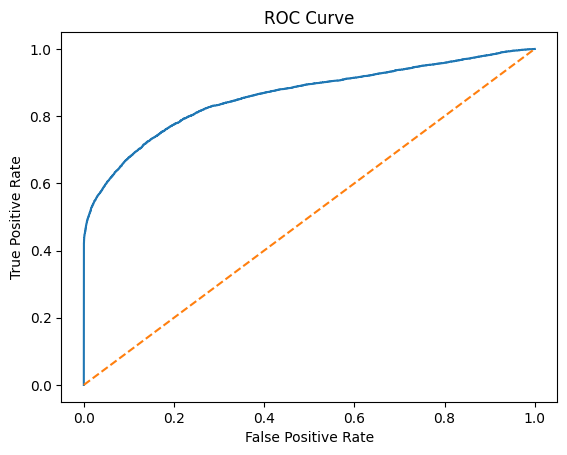

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [16]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})

feature_importance['abs_coef'] = feature_importance['coefficient'].abs()
feature_importance.sort_values('abs_coef', ascending=False).head(10)

,feature,coefficient,abs_coef
34,credit_type_EQUI,3.333903,3.333903
43,submission_of_application_to_inst,0.639533,0.639533
8,LTV,0.610782,0.610782
3,Upfront_charges,-0.514375,0.514375
2,Interest_rate_spread,-0.470342,0.470342
25,lump_sum_payment_not_lpsm,-0.387668,0.387668
23,Neg_ammortization_not_neg,-0.327914,0.327914
27,occupancy_type_pr,-0.322430,0.322430
16,loan_type_type3,-0.315156,0.315156
6,income,-0.297191,0.297191
